# Feature selection

A common theme in machine learning is selecting good features in other to maximize model performance.

For structured datasets, there are usually two steps in order to choose a final set of features:

1. **Feature engineering**: creating new features from data (eg. from unit price and total volume, maybe create a total revenue feature, equal to price $\times$ volume)
2. **Feature selection**: from a set of $p$ features, select a subset which keeps (or even improves) performance 

In order to accomplish these, there exist both **technical** and **business** considerations. We won't cover the latter: these are usually application-specific and, most importantly, heavily dependent on the data you have at hand. 

Therefore, we will stick to technical methods to perform feature selection: given a set of features $x_1, \ldots, x_p$, can we select a subset $x_1',\ldots, x_m'$ (where $m$ here stands for "minimal") which lead us to an optimal level of model performance?

> For the remainder of this section, $N$ will denote the amount of samples (ie. we are given a dataset $\{x_i, y_i\}_{i\in 1:N}$) and $p$ will denote the original amount of features (that is, each $x_i$ is a $p$-dimensional vector).

### How much is too much?

One (old) common answer is that $p > N$ means too many features. This was always the case in traditional statistics, for methods such as linear or logistic regression for which $p > N$ literally means that the algorithm breaks down (see https://stats.stackexchange.com/questions/282663/why-is-n-p-a-problem-for-ols-regression), since the $X^T X$ matrix is no longer invertible.

This is no longer a satisfactory answer. Indeed, it is common in genomics, for example, to have datasets where $p \gg N$: gene expression data usually considers $p$ on the order of 10,000 or even 100,000 thousand, whereas $N$ might be around a few hundred (one for each patient in the study, for example). 

The same can be seen in problems like image processing, where each pixel contributes with $O(1)$ features. As image sizes get larger, total feature count scales quadratically. 

For credit, in our exprience, it is common to have datasets with $p$ between 100-10,000 features pertaining to an individual's financial, behavioral and demographical information. $N$ here will usually be on the order of 100,000 - 100 million, ie. some percentage of the population (we are considering the Brazilian case with total population around 200 million).

Let us focus on the credit example. Do we *need* 5000 features to predict an individual's credit behaviour? There is no reason why that would not be the case; however, experience shows that we can get very good predictions with values between 20-400 features (ie. ~0.5% to 10% of the total features). This is a data-driven insight, since a Pareto-like rule tends to apply to feature importance measures. 

**There are always useless features**. In the genomics case, not all genes are active at a given moment - only a fraction of them contribute to whatever phenomenon is of interest. In a 800x600 image of a cat, only a small portion of pixels will indeed describe the cat, with the rest being objects which are not of interest. Similarly, as rich information as an individual's features might be, only some will contribute to their credit behavior. 

Our goal is then to find **systematic ways to filter out useless features**.

### What are the trade-offs here?

It is common sense that, if you have too few features, your model might simply not have enough information to perform well.

Less obvious is that too many features can also be problematic. They might cause loss of performance due to a few related reasons:
* Overfitting: the more features, the more difficult will it be for points to have close neighbors (the so-called curse of dimensionality); you will need exponentially more data to cover the feature space meaningfully. Your algorithm is prone to just overfitting
* Noise: useless variables introduce noise which can affect training
* Time/space considerations: the more dimensions, the more memory it takes on your computer, and the longer it will take for training, hyperparameter optimization etc

# Boruta

One of our favorite methods for feature selection is the Boruta algorithm, introduced in 2010 by Kursa and Rudnicki [1]. It has consistently proven itself as a powerful tool for straightforward selection of good features in the case of thousands of features.

> A nice pedagogical overview of the method by the original author can be seen at https://cran.r-project.org/web/packages/Boruta/vignettes/inahurry.pdf

> The Python implementation (BorutaPy) can be seen at https://github.com/scikit-learn-contrib/boruta_py

Simply stated, Boruta works as follows. For each feature, say `x1`, Boruta creates a copy `x1_copy` (called a *shadow* by the authors) and then randomly mixes the values across all points, creating noise. 


It then fits a model (usually a random forest) implementing a feature importance method, and analyses how the original feature's importance compares to the noisy copies. If they are significantly different, then `x1` is deemed valuable, and kept; if they are not, it means `x1` itself is basically noise, and it is removed.

### Using Boruta in practice

We will use Boruta with random forests.

As noted by the author itself (in *Boruta for those in a hurry*, Miron B. Kursa, May 21 2020), it is important that we have enough trees:
> For datasets with lots of features, the default configuration of the importance source is likely insufficient; in the particular case of Random Forest the number of trees is often not large enough to allow the importance scores to stabilise, which in turn often leads to false negatives and unstable results.

This can be taken care of by letting Boruta itself identify an optimal number of trees (as we do below).

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from boruta.boruta_py import BorutaPy

Create a balanced classification problem with 30 features, out of which:
* 6 are informative
* 4 are redundant linear combinations of the informative ones
* 5 are just repeated values
* 15 are random noise

To all features, we add some Gaussian noise to avoid perfect collinearity.

We will name the columns accordingly, and see which are kept by Boruta and which are taken out.

In [155]:
X, y = make_classification(n_samples=10000, 
                           n_features=30, n_informative=6, n_repeated=5, n_redundant=4,
                           random_state=2,
                           weights=(0.5,),
                           shuffle=False)

X += 0.5*np.random.randn(*X.shape)

columns = [f'informative_{i}' for i in range(6)] + \
          [f'redundant_{i}' for i in range(4)] + \
          [f'repeated_{i}' for i in range(5)] + \
          [f'noise_{i}' for i in range(15)]

X = pd.DataFrame(X, columns=columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [158]:
def select_feature_boruta(X, y, 
                         perc=100,
                         alpha=0.05,
                         max_iter=100,
                         max_depth=7,
                         n_estimators='auto',
                         n_jobs=1):

    from sklearn.ensemble import RandomForestClassifier
    from boruta.boruta_py import BorutaPy
    
    X_is_df = isinstance(X, pd.DataFrame)
    y_is_df = isinstance(y, pd.Series)
    
    selector = BorutaPy(
        estimator=RandomForestClassifier(n_estimators=100, max_depth=max_depth, n_jobs=n_jobs),
        n_estimators=n_estimators,
        perc=perc,      
        alpha=alpha,    
        max_iter=max_iter,
        random_state=1,
        verbose=0,
    )

    # boruta needs a numpy array, not a dataframe
    X_train = X.values if X_is_df else X
    y_train = y.values if y_is_df else y

    selector.fit(X_train, y_train) 
    
    if X_is_df:
        columns = X.columns
        return sorted(np.array(columns)[selector.support_.tolist()])
    else:
        return sorted(selector.support_.tolist())

Let us print the features which survive the feature selection process:

In [159]:
%%time
selected_features = select_feature_boruta(X_train, y_train, n_jobs=10)
selected_features

CPU times: user 34.3 s, sys: 671 ms, total: 34.9 s
Wall time: 6.47 s


['informative_0',
 'informative_1',
 'informative_2',
 'informative_3',
 'informative_4',
 'informative_5',
 'redundant_0',
 'redundant_1',
 'redundant_2',
 'redundant_3',
 'repeated_0',
 'repeated_1',
 'repeated_2',
 'repeated_3',
 'repeated_4']

*All* non-random features survived in the end! This is expected: Boruta is *not meant* to remove repeated or redundant features. Since these features appear as having significant feature importance, it will keep them; it is our job as data scientists to remove collinearity. We can use the code below to do that first, then run Boruta:

In [163]:
def drop_high_correlations(df, thresh=0.95):
    corr_matrix = df.corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > thresh)]

    return df.drop(to_drop, axis=1)

In [164]:
%%time
X_train_uncor = drop_high_correlations(X_train, thresh=0.9)
selected_features = select_feature_boruta(X_train_uncor, y_train, n_jobs=20)
selected_features

CPU times: user 30.9 s, sys: 719 ms, total: 31.6 s
Wall time: 5.54 s


['informative_0',
 'informative_1',
 'informative_2',
 'informative_3',
 'informative_4',
 'informative_5',
 'redundant_0',
 'redundant_1',
 'redundant_2',
 'redundant_3',
 'repeated_1',
 'repeated_4']

With a threshold of 0.9, this approach removes some of the repeated features, as we would have liked.

Boruta has some free parameters which might be useful. For example, the `perc` parameter determines how strict we want to be when comparing real features with shadow features. If we choose a lower `perc`, more features could survive. In practice, try studying `perc` between 90 and 100.

# Using SHAP values

A common approach is to calculate SHAP values and then remove the features with total contribution less than a certain threshold. This has some ambiguity on the threshold definition, and also needs to be done iteratively - after removing features, one must retrain and see the new SHAP values.

In [165]:
import shap
from sklearn.ensemble import HistGradientBoostingClassifier

In [166]:
model = HistGradientBoostingClassifier(random_state=2, max_depth=5)
model.fit(X_train, y_train)

HistGradientBoostingClassifier(max_depth=5, random_state=2)

In [167]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

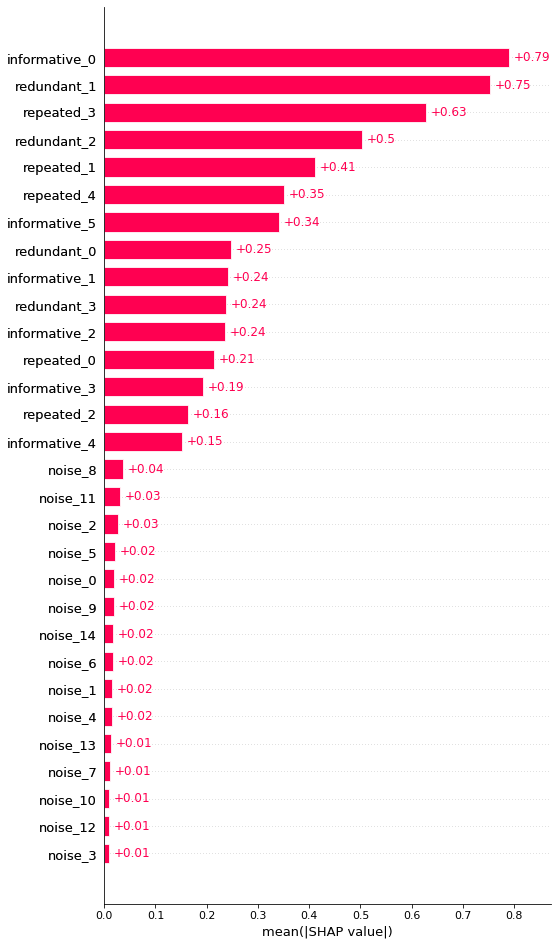

In [168]:
shap.plots.bar(shap_values, max_display=None, show=False)

We see that SHAP does a good job of finding that the noise features don't add value. Here, clearly a threshold of `mean(|SHAP|) > 0.05` seems to be a good feature selector, but this is something we have to identify visually. 

We can make this process into a function:
    

In [169]:
def shap_importances(columns, shap_values):
    importances = np.abs(shap_values.values).mean(axis=0)  # same calculation as the bar plot 
    feats_imps = pd.DataFrame({'feature': columns, 
                               'shap': importances})
    
    return feats_imps.sort_values('shap', ascending=False)

def get_important_features_from_shap(importances, threshold=0.04):
    imps = importances[importances['shap'] > threshold]
    return sorted(imps['feature'].tolist())

In [170]:
importances = shap_importances(X.columns, shap_values)
importances.head()

,feature,shap
0,informative_0,0.790061
7,redundant_1,0.751999
13,repeated_3,0.627386
8,redundant_2,0.503884
11,repeated_1,0.411533


In [171]:
features_selected_shap = get_important_features_from_shap(importances, threshold=0.05)

Rinse and repeat:

In [172]:
model = HistGradientBoostingClassifier(random_state=2, max_depth=5)
model.fit(X_train[features_selected_shap], y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train[features_selected_shap])

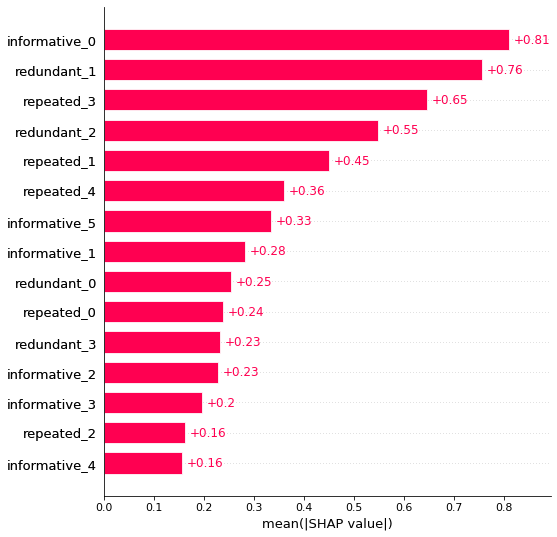

In [173]:
shap.plots.bar(shap_values, max_display=None, show=False)

There has been some rearrangement, but overall this process works. No noise features are present, but the repeated / redundant features have remained.

# Experiments

### How well does Boruta perform when we increase the number of junk variables?

It is interesting to study how will Boruta perform in the following scenarios: we keep the total amount of points fixed, but steadily increase the number of features, and then:
1. Keep the number of informative features fixed, and instead grow the number of junk variables
2. Keep the proportion between informative and junk variables fixed as we grow the total


### 1) Fixed number of informative features

In [197]:
from tqdm.notebook import tqdm

In [254]:
feature_lengths_list = list(range(30,1030,30))

In [235]:
experiment_results = {}
informative = 10
redundant   = 5
repeated    = 5
for total_features in tqdm(feature_lengths_list):

    noise       = total_features-informative-redundant-repeated


    """Create data"""
    X, y = make_classification(n_samples=3000, 
                               n_features=total_features, n_informative=informative, 
                               n_repeated=repeated, n_redundant=redundant,
                               random_state=2,
                               weights=(0.5,),
                               shuffle=False)

    X += 0.5*np.random.randn(*X.shape)

    good_features = [f'informative_{i}' for i in range(informative)] + \
              [f'redundant_{i}' for i in range(redundant)] + \
              [f'repeated_{i}' for i in range(repeated)]

    columns = good_features + \
              [f'noise_{i}' for i in range(noise)]

    X = pd.DataFrame(X, columns=columns)
    
    """Run Boruta and save results"""
    selected_features = select_feature_boruta(X, y, n_jobs=10)
    
    experiment_results.update({total_features: [set(good_features), set(selected_features)]})

  0%|          | 0/34 [00:00<?, ?it/s]

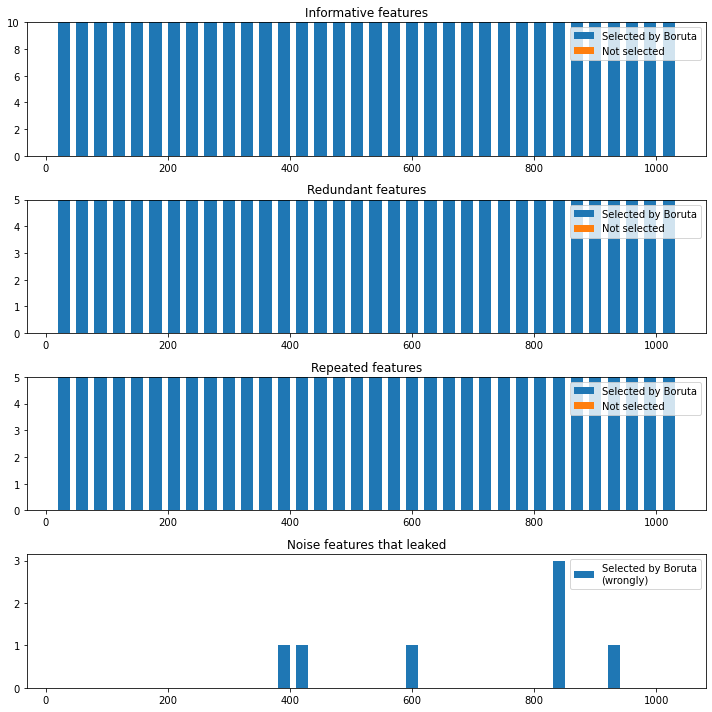

In [315]:
found_list_info, diff_list_info = [], []
found_list_red, diff_list_red = [], []
found_list_rep, diff_list_rep = [], []
found_list_noise, diff_list_noise = [], []

for total_features in feature_lengths_list:
    aux = experiment_results[total_features]
    good_cols = aux[0]
    boruta_cols = aux[1]
    
    # get sets
    base_informatives = set(filter(lambda col: 'informative' in col, good_cols))
    base_redundants = set(filter(lambda col: 'redundant' in col, good_cols))
    base_repeated = set(filter(lambda col: 'repeated' in col, good_cols))

    boruta_informatives = set(filter(lambda col: 'informative' in col, boruta_cols))
    boruta_redundants = set(filter(lambda col: 'redundant' in col, boruta_cols))
    boruta_repeated = set(filter(lambda col: 'repeated' in col, boruta_cols))
    boruta_noise = set(filter(lambda col: 'noise' in col, boruta_cols))

    # 1) informatives
    found, total = len(boruta_informatives), len(base_informatives)
    diff = total - found
    
    found_list_info.append(found); diff_list_info.append(diff)
    
    # 2) redundant
    found, total = len(boruta_redundants), len(base_redundants)
    diff = total - found
    
    found_list_red.append(found); diff_list_red.append(diff)
    
    # 3) repeated
    found, total = len(boruta_repeated), len(base_repeated)
    diff = total - found
    
    found_list_rep.append(found); diff_list_rep.append(diff)
    
    # 4) noise
    found = len(boruta_noise)

    found_list_noise.append(found)

fig, ax = plt.subplots(nrows=4, figsize=(10,10))
ax[0].bar(feature_lengths_list, found_list_info, width=20, label='Selected by Boruta')
ax[0].bar(feature_lengths_list, diff_list_info, bottom=found_list_info, width=20, label='Not selected')
ax[0].set_title("Informative features")
ax[0].legend()

ax[1].bar(feature_lengths_list, found_list_red, width=20, label='Selected by Boruta')
ax[1].bar(feature_lengths_list, diff_list_red, bottom=found_list_red, width=20, label='Not selected')
ax[1].set_title("Redundant features")
ax[1].legend()

ax[2].bar(feature_lengths_list, found_list_rep, width=20, label='Selected by Boruta')
ax[2].bar(feature_lengths_list, diff_list_rep, bottom=found_list_rep, width=20, label='Not selected')
ax[2].set_title("Repeated features")
ax[2].legend()

ax[3].bar(feature_lengths_list, found_list_noise, width=20, label='Selected by Boruta\n(wrongly)')
ax[3].set_title("Noise features that leaked")
ax[3].legend()

plt.tight_layout()
plt.show()

As we can see, even in the case of 1000 features (on 3000 datapoints), Boruta does an excellent job of filtering out the noise features. It did let a few noisy features leak when when the number of total features increased, but it was minor.

## 2) Proportional number of significative features

We repeat the experiment above, but now scale the amount of informative, redundant and repeated features with the total amount of features. More specifically, for a total of $p$ features, we set
* Total informative features: $\lfloor 0.3n\rfloor$
* Total redundant features: $\lfloor 0.1n\rfloor$
* Total repeated features: $\lfloor 0.1n\rfloor$
where $\lfloor\cdot\rfloor$ denotes the floor operation.

In [275]:
experiment_results_proportional = {}
for total_features in tqdm(feature_lengths_list):

    # proportions
    informative_prop = 0.3
    redundant_prop = 0.1
    repeated_prop = 0.1
    
    informative = int(informative_prop * total_features)
    redundant   = int(redundant_prop * total_features)
    repeated    = int(repeated_prop * total_features)
    noise       = total_features-informative-redundant-repeated


    """Create data"""
    X, y = make_classification(n_samples=3000, 
                               n_features=total_features, n_informative=informative, 
                               n_repeated=repeated, n_redundant=redundant,
                               random_state=2,
                               weights=(0.5,),
                               shuffle=False)

    X += 0.5*np.random.randn(*X.shape)

    good_features = [f'informative_{i}' for i in range(informative)] + \
              [f'redundant_{i}' for i in range(redundant)] + \
              [f'repeated_{i}' for i in range(repeated)]

    columns = good_features + \
              [f'noise_{i}' for i in range(noise)]

    X = pd.DataFrame(X, columns=columns)
    
    """Run Boruta and save results"""
    selected_features = select_feature_boruta(X, y, n_jobs=10)
    
    experiment_results_proportional.update({total_features: [set(good_features), set(selected_features)]})

  0%|          | 0/34 [00:00<?, ?it/s]

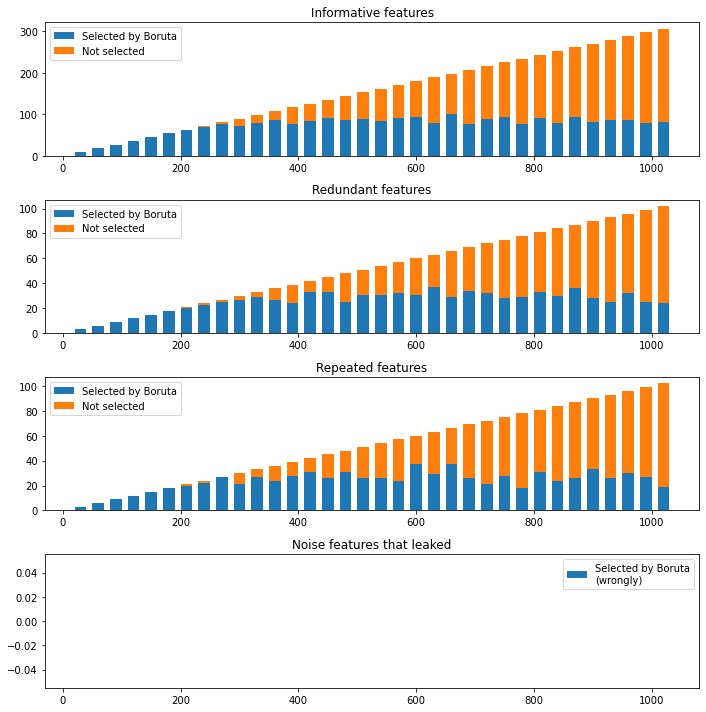

In [316]:
found_list_info, diff_list_info = [], []
found_list_red, diff_list_red = [], []
found_list_rep, diff_list_rep = [], []
found_list_noise, diff_list_noise = [], []

for total_features in feature_lengths_list:
    aux = experiment_results_proportional[total_features]
    good_cols = aux[0]
    boruta_cols = aux[1]
    
    # get sets
    base_informatives = set(filter(lambda col: 'informative' in col, good_cols))
    base_redundants = set(filter(lambda col: 'redundant' in col, good_cols))
    base_repeated = set(filter(lambda col: 'repeated' in col, good_cols))

    boruta_informatives = set(filter(lambda col: 'informative' in col, boruta_cols))
    boruta_redundants = set(filter(lambda col: 'redundant' in col, boruta_cols))
    boruta_repeated = set(filter(lambda col: 'repeated' in col, boruta_cols))
    boruta_noise = set(filter(lambda col: 'noise' in col, boruta_cols))

    # 1) informatives
    found, total = len(boruta_informatives), len(base_informatives)
    diff = total - found
    
    found_list_info.append(found); diff_list_info.append(diff)
    
    # 2) redundant
    found, total = len(boruta_redundants), len(base_redundants)
    diff = total - found
    
    found_list_red.append(found); diff_list_red.append(diff)
    
    # 3) repeated
    found, total = len(boruta_repeated), len(base_repeated)
    diff = total - found
    
    found_list_rep.append(found); diff_list_rep.append(diff)
    
    # 4) noise
    found = len(boruta_noise)

    found_list_noise.append(found)

fig, ax = plt.subplots(nrows=4, figsize=(10,10))
ax[0].bar(feature_lengths_list, found_list_info, width=20, label='Selected by Boruta')
ax[0].bar(feature_lengths_list, diff_list_info, bottom=found_list_info, width=20, label='Not selected')
ax[0].set_title("Informative features")
ax[0].legend()

ax[1].bar(feature_lengths_list, found_list_red, width=20, label='Selected by Boruta')
ax[1].bar(feature_lengths_list, diff_list_red, bottom=found_list_red, width=20, label='Not selected')
ax[1].set_title("Redundant features")
ax[1].legend()

ax[2].bar(feature_lengths_list, found_list_rep, width=20, label='Selected by Boruta')
ax[2].bar(feature_lengths_list, diff_list_rep, bottom=found_list_rep, width=20, label='Not selected')
ax[2].set_title("Repeated features")
ax[2].legend()

ax[3].bar(feature_lengths_list, found_list_noise, width=20, label='Selected by Boruta\n(wrongly)')
ax[3].set_title("Noise features that leaked")
ax[3].legend()

plt.tight_layout()
plt.show()

We see that in this case, after a certain amount of total features, Boruta starts getting blind; it stops capturing features among the informative, repeated and redundant categories.

In other words - Boruta's ability to capture all useful features reaches a ceiling after a certain point (in our case, it was around 160 features regardless of the total feature count). 

# Repeating the experiment with deeper trees / longer runs

In [318]:
experiment_results_deeper = {}
for total_features in tqdm(feature_lengths_list):

    # proportions
    informative_prop = 0.3
    redundant_prop = 0.1
    repeated_prop = 0.1
    
    informative = int(informative_prop * total_features)
    redundant   = int(redundant_prop * total_features)
    repeated    = int(repeated_prop * total_features)
    noise       = total_features-informative-redundant-repeated


    """Create data"""
    X, y = make_classification(n_samples=3000, 
                               n_features=total_features, n_informative=informative, 
                               n_repeated=repeated, n_redundant=redundant,
                               random_state=2,
                               weights=(0.5,),
                               shuffle=False)

    X += 0.5*np.random.randn(*X.shape)

    good_features = [f'informative_{i}' for i in range(informative)] + \
              [f'redundant_{i}' for i in range(redundant)] + \
              [f'repeated_{i}' for i in range(repeated)]

    columns = good_features + \
              [f'noise_{i}' for i in range(noise)]

    X = pd.DataFrame(X, columns=columns)
    
    """Run Boruta and save results"""
    selected_features = select_feature_boruta(X, y, n_jobs=10,
                                             max_depth=11,     # adding more depth here
                                             n_estimators=500) # adding more estimators by hand
    
    experiment_results_deeper.update({total_features: [set(good_features), set(selected_features)]})

  0%|          | 0/34 [00:00<?, ?it/s]

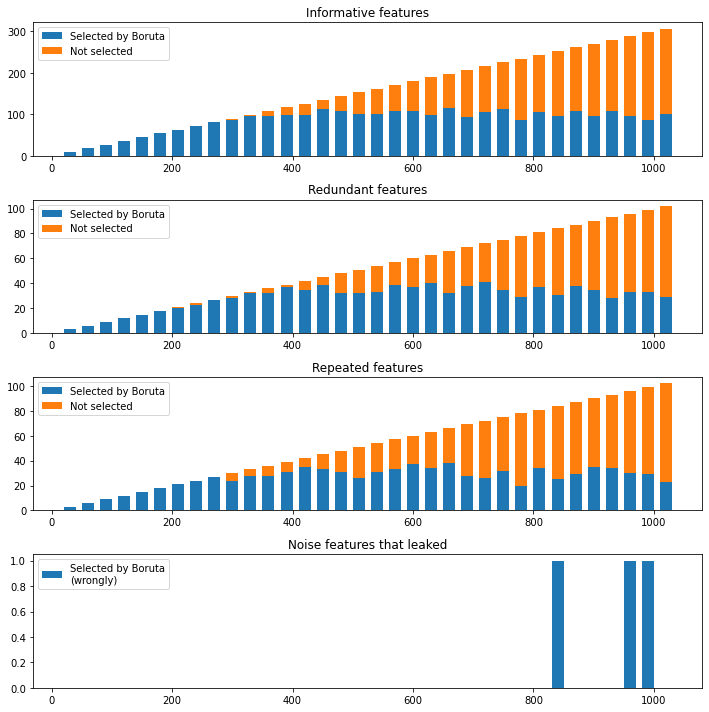

In [319]:
found_list_info, diff_list_info = [], []
found_list_red, diff_list_red = [], []
found_list_rep, diff_list_rep = [], []
found_list_noise, diff_list_noise = [], []

for total_features in feature_lengths_list:
    aux = experiment_results_deeper[total_features]
    good_cols = aux[0]
    boruta_cols = aux[1]
    
    # get sets
    base_informatives = set(filter(lambda col: 'informative' in col, good_cols))
    base_redundants = set(filter(lambda col: 'redundant' in col, good_cols))
    base_repeated = set(filter(lambda col: 'repeated' in col, good_cols))

    boruta_informatives = set(filter(lambda col: 'informative' in col, boruta_cols))
    boruta_redundants = set(filter(lambda col: 'redundant' in col, boruta_cols))
    boruta_repeated = set(filter(lambda col: 'repeated' in col, boruta_cols))
    boruta_noise = set(filter(lambda col: 'noise' in col, boruta_cols))

    # 1) informatives
    found, total = len(boruta_informatives), len(base_informatives)
    diff = total - found
    
    found_list_info.append(found); diff_list_info.append(diff)
    
    # 2) redundant
    found, total = len(boruta_redundants), len(base_redundants)
    diff = total - found
    
    found_list_red.append(found); diff_list_red.append(diff)
    
    # 3) repeated
    found, total = len(boruta_repeated), len(base_repeated)
    diff = total - found
    
    found_list_rep.append(found); diff_list_rep.append(diff)
    
    # 4) noise
    found = len(boruta_noise)

    found_list_noise.append(found)

fig, ax = plt.subplots(nrows=4, figsize=(10,10))
ax[0].bar(feature_lengths_list, found_list_info, width=20, label='Selected by Boruta')
ax[0].bar(feature_lengths_list, diff_list_info, bottom=found_list_info, width=20, label='Not selected')
ax[0].set_title("Informative features")
ax[0].legend()

ax[1].bar(feature_lengths_list, found_list_red, width=20, label='Selected by Boruta')
ax[1].bar(feature_lengths_list, diff_list_red, bottom=found_list_red, width=20, label='Not selected')
ax[1].set_title("Redundant features")
ax[1].legend()

ax[2].bar(feature_lengths_list, found_list_rep, width=20, label='Selected by Boruta')
ax[2].bar(feature_lengths_list, diff_list_rep, bottom=found_list_rep, width=20, label='Not selected')
ax[2].set_title("Repeated features")
ax[2].legend()

ax[3].bar(feature_lengths_list, found_list_noise, width=20, label='Selected by Boruta\n(wrongly)')
ax[3].set_title("Noise features that leaked")
ax[3].legend()

plt.tight_layout()
plt.show()

# Try one more - increase max iter

  0%|          | 0/34 [00:00<?, ?it/s]

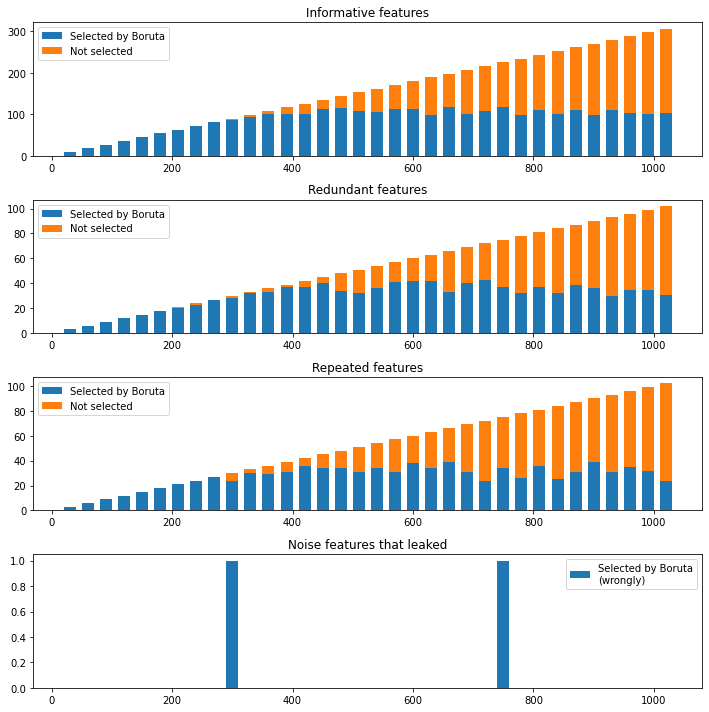

In [320]:
experiment_results_deeper = {}
for total_features in tqdm(feature_lengths_list):

    # proportions
    informative_prop = 0.3
    redundant_prop = 0.1
    repeated_prop = 0.1
    
    informative = int(informative_prop * total_features)
    redundant   = int(redundant_prop * total_features)
    repeated    = int(repeated_prop * total_features)
    noise       = total_features-informative-redundant-repeated


    """Create data"""
    X, y = make_classification(n_samples=3000, 
                               n_features=total_features, n_informative=informative, 
                               n_repeated=repeated, n_redundant=redundant,
                               random_state=2,
                               weights=(0.5,),
                               shuffle=False)

    X += 0.5*np.random.randn(*X.shape)

    good_features = [f'informative_{i}' for i in range(informative)] + \
              [f'redundant_{i}' for i in range(redundant)] + \
              [f'repeated_{i}' for i in range(repeated)]

    columns = good_features + \
              [f'noise_{i}' for i in range(noise)]

    X = pd.DataFrame(X, columns=columns)
    
    """Run Boruta and save results"""
    selected_features = select_feature_boruta(X, y, n_jobs=10,
                                             max_depth=11,     # adding more depth here
                                             max_iter=200,
                                             n_estimators=500) # adding more estimators by hand
    
    experiment_results_deeper.update({total_features: [set(good_features), set(selected_features)]})

found_list_info, diff_list_info = [], []
found_list_red, diff_list_red = [], []
found_list_rep, diff_list_rep = [], []
found_list_noise, diff_list_noise = [], []

for total_features in feature_lengths_list:
    aux = experiment_results_deeper[total_features]
    good_cols = aux[0]
    boruta_cols = aux[1]
    
    # get sets
    base_informatives = set(filter(lambda col: 'informative' in col, good_cols))
    base_redundants = set(filter(lambda col: 'redundant' in col, good_cols))
    base_repeated = set(filter(lambda col: 'repeated' in col, good_cols))

    boruta_informatives = set(filter(lambda col: 'informative' in col, boruta_cols))
    boruta_redundants = set(filter(lambda col: 'redundant' in col, boruta_cols))
    boruta_repeated = set(filter(lambda col: 'repeated' in col, boruta_cols))
    boruta_noise = set(filter(lambda col: 'noise' in col, boruta_cols))

    # 1) informatives
    found, total = len(boruta_informatives), len(base_informatives)
    diff = total - found
    
    found_list_info.append(found); diff_list_info.append(diff)
    
    # 2) redundant
    found, total = len(boruta_redundants), len(base_redundants)
    diff = total - found
    
    found_list_red.append(found); diff_list_red.append(diff)
    
    # 3) repeated
    found, total = len(boruta_repeated), len(base_repeated)
    diff = total - found
    
    found_list_rep.append(found); diff_list_rep.append(diff)
    
    # 4) noise
    found = len(boruta_noise)

    found_list_noise.append(found)

fig, ax = plt.subplots(nrows=4, figsize=(10,10))
ax[0].bar(feature_lengths_list, found_list_info, width=20, label='Selected by Boruta')
ax[0].bar(feature_lengths_list, diff_list_info, bottom=found_list_info, width=20, label='Not selected')
ax[0].set_title("Informative features")
ax[0].legend()

ax[1].bar(feature_lengths_list, found_list_red, width=20, label='Selected by Boruta')
ax[1].bar(feature_lengths_list, diff_list_red, bottom=found_list_red, width=20, label='Not selected')
ax[1].set_title("Redundant features")
ax[1].legend()

ax[2].bar(feature_lengths_list, found_list_rep, width=20, label='Selected by Boruta')
ax[2].bar(feature_lengths_list, diff_list_rep, bottom=found_list_rep, width=20, label='Not selected')
ax[2].set_title("Repeated features")
ax[2].legend()

ax[3].bar(feature_lengths_list, found_list_noise, width=20, label='Selected by Boruta\n(wrongly)')
ax[3].set_title("Noise features that leaked")
ax[3].legend()

plt.tight_layout()
plt.show()

# Only significant and noise

In [321]:
experiment_results_deeper = {}
for total_features in tqdm(feature_lengths_list):

    # proportions
    informative_prop = 0.3
    redundant_prop = 0.0
    repeated_prop = 0.0
    
    informative = int(informative_prop * total_features)
    redundant   = int(redundant_prop * total_features)
    repeated    = int(repeated_prop * total_features)
    noise       = total_features-informative-redundant-repeated


    """Create data"""
    X, y = make_classification(n_samples=3000, 
                               n_features=total_features, n_informative=informative, 
                               n_repeated=repeated, n_redundant=redundant,
                               random_state=2,
                               weights=(0.5,),
                               shuffle=False)

    X += 0.5*np.random.randn(*X.shape)

    good_features = [f'informative_{i}' for i in range(informative)] + \
              [f'redundant_{i}' for i in range(redundant)] + \
              [f'repeated_{i}' for i in range(repeated)]

    columns = good_features + \
              [f'noise_{i}' for i in range(noise)]

    X = pd.DataFrame(X, columns=columns)
    
    """Run Boruta and save results"""
    selected_features = select_feature_boruta(X, y, n_jobs=10,
                                             max_depth=11,     # adding more depth here
                                             max_iter=200,
                                             n_estimators=500) # adding more estimators by hand
    
    experiment_results_deeper.update({total_features: [set(good_features), set(selected_features)]})

  0%|          | 0/34 [00:00<?, ?it/s]

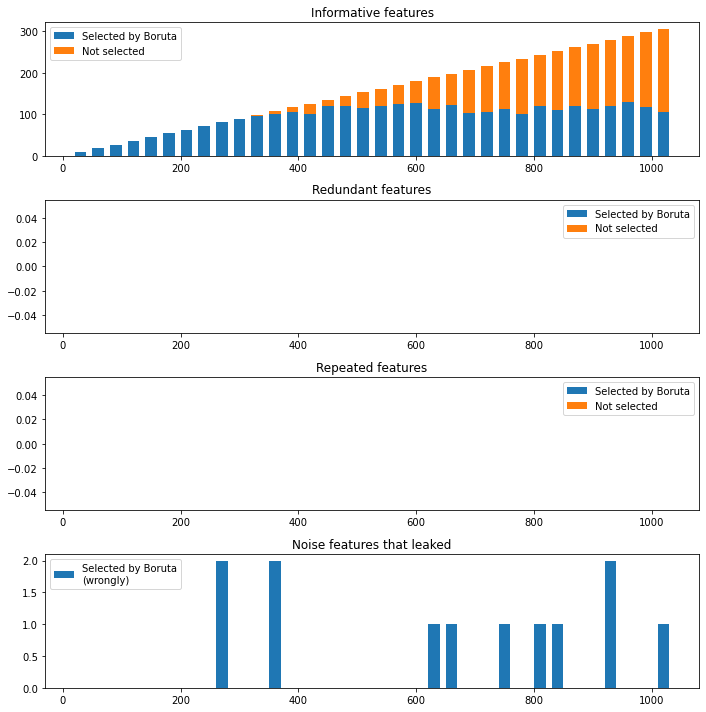

In [322]:
found_list_info, diff_list_info = [], []
found_list_red, diff_list_red = [], []
found_list_rep, diff_list_rep = [], []
found_list_noise, diff_list_noise = [], []

for total_features in feature_lengths_list:
    aux = experiment_results_deeper[total_features]
    good_cols = aux[0]
    boruta_cols = aux[1]
    
    # get sets
    base_informatives = set(filter(lambda col: 'informative' in col, good_cols))
    base_redundants = set(filter(lambda col: 'redundant' in col, good_cols))
    base_repeated = set(filter(lambda col: 'repeated' in col, good_cols))

    boruta_informatives = set(filter(lambda col: 'informative' in col, boruta_cols))
    boruta_redundants = set(filter(lambda col: 'redundant' in col, boruta_cols))
    boruta_repeated = set(filter(lambda col: 'repeated' in col, boruta_cols))
    boruta_noise = set(filter(lambda col: 'noise' in col, boruta_cols))

    # 1) informatives
    found, total = len(boruta_informatives), len(base_informatives)
    diff = total - found
    
    found_list_info.append(found); diff_list_info.append(diff)
    
    # 2) redundant
    found, total = len(boruta_redundants), len(base_redundants)
    diff = total - found
    
    found_list_red.append(found); diff_list_red.append(diff)
    
    # 3) repeated
    found, total = len(boruta_repeated), len(base_repeated)
    diff = total - found
    
    found_list_rep.append(found); diff_list_rep.append(diff)
    
    # 4) noise
    found = len(boruta_noise)

    found_list_noise.append(found)

fig, ax = plt.subplots(nrows=4, figsize=(10,10))
ax[0].bar(feature_lengths_list, found_list_info, width=20, label='Selected by Boruta')
ax[0].bar(feature_lengths_list, diff_list_info, bottom=found_list_info, width=20, label='Not selected')
ax[0].set_title("Informative features")
ax[0].legend()

ax[1].bar(feature_lengths_list, found_list_red, width=20, label='Selected by Boruta')
ax[1].bar(feature_lengths_list, diff_list_red, bottom=found_list_red, width=20, label='Not selected')
ax[1].set_title("Redundant features")
ax[1].legend()

ax[2].bar(feature_lengths_list, found_list_rep, width=20, label='Selected by Boruta')
ax[2].bar(feature_lengths_list, diff_list_rep, bottom=found_list_rep, width=20, label='Not selected')
ax[2].set_title("Repeated features")
ax[2].legend()

ax[3].bar(feature_lengths_list, found_list_noise, width=20, label='Selected by Boruta\n(wrongly)')
ax[3].set_title("Noise features that leaked")
ax[3].legend()

plt.tight_layout()
plt.show()

## Real-data case: genomics data

# Imbalanced cases

# Some acknowledgements

One interesting approach is to use a mix of Boruta and SHAP values: instead of using the feature importances calculated during the model training, we would instead use SHAP values.

> In tree-based classification models, splits are calculated based on Gini impurity or infomation gain. A split into new branches happens when a feature is found to decrease the total impurity. Feature importance for a given feature in a decision tree is then how much that feature contributed to the total impurity reduction. For a random forest, the feature importance attribute is the average over all trees in the forest. More details on https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

The Boruta-SHAP library [2] does exactly that. Below, we see how to use it.
> Because SHAP value calculation is an expensive operation, this process might take much longer than the equivalent with standard feature importances.

In [177]:
from BorutaShap import BorutaShap

In [180]:
# important to pass the specific model to use; otherwise it can take a long time
selector = BorutaShap(model=RandomForestClassifier(n_estimators=100, max_depth=7, n_jobs=10),
                      percentile=100,
                      pvalue=0.05,
                      importance_measure='shap',
                      classification=True)

selector.fit(X_train, y_train,
             n_trials=100, sample=False,
             train_or_test='test', normalize=True,
             verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

15 attributes confirmed important: ['informative_3', 'repeated_1', 'repeated_3', 'informative_1', 'informative_5', 'repeated_2', 'informative_4', 'informative_0', 'redundant_3', 'redundant_0', 'redundant_1', 'redundant_2', 'repeated_4', 'repeated_0', 'informative_2']
15 attributes confirmed unimportant: ['noise_0', 'noise_12', 'noise_8', 'noise_9', 'noise_2', 'noise_7', 'noise_3', 'noise_6', 'noise_13', 'noise_4', 'noise_1', 'noise_11', 'noise_14', 'noise_10', 'noise_5']
0 tentative attributes remains: []


In [182]:
selected_columns = sorted(list(selector.Subset().columns))

In [183]:
selected_columns

['informative_0',
 'informative_1',
 'informative_2',
 'informative_3',
 'informative_4',
 'informative_5',
 'redundant_0',
 'redundant_1',
 'redundant_2',
 'redundant_3',
 'repeated_0',
 'repeated_1',
 'repeated_2',
 'repeated_3',
 'repeated_4']

It gets the right columns, but this is an extremely time-consuming algorithm. Hopefully it can be accelerated in the near future.

# References

Virus infection dataset NCBI GSE73072
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE73072

[1] Kursa, M. B., & Rudnicki, W. R. (2010). Feature Selection with the Boruta Package. Journal of Statistical Software, 36(11), 1–13. https://doi.org/10.18637/jss.v036.i11

[2] https://github.com/Ekeany/Boruta-Shap